In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

import pickle
import optuna

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, LSTM, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings('ignore')
%matplotlib inline


In [111]:
with open('../data/crypto_currency.pickle','rb') as f:
    data = pickle.load(f)
    
btt = data['KRW-ETH']
btt = btt.set_index('candle_date_time_kst')

WINDOW_SIZE = 20
BATCH_SIZE = 32
TRAIN_SIZE = 0.8

scaler = MinMaxScaler()
scale_cols = ['change_rate','candle_acc_trade_volume','trade_price']
scaled = scaler.fit_transform(btt[scale_cols])
n_train = int(np.floor(scaled.shape[0] * TRAIN_SIZE))
train = scaled[:n_train]
test = scaled[n_train-WINDOW_SIZE:]


def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)


def window_dataset(series, window_size, batch_size, shuffle):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w : w.batch(window_size+1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w : (w[:-1],w[-1][2]))
    return ds.batch(batch_size).prefetch(1)



def get_model(trial):
    model = Sequential([
                Conv1D(filters=trial.suggest_int('filters',8,64,step=8), 
                       kernel_size=trial.suggest_int('kernel_size',3,10),
                       padding = 'causal',
                       activation = 'relu',
                       input_shape = [WINDOW_SIZE, 3] 
                      ),
                LSTM(trial.suggest_int('n_LSTM',16,128,step=8), activation='tanh'),
                Dense(trial.suggest_int('n_Dense',16,128,step=8), activation = 'relu'),
                Dense(1)
            ])
    return model
    
    
def get_optimizer(trial):
    kwargs = {}
    optimizer_options = ["Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer


def get_tensor_data():
    train_data = window_dataset(train, WINDOW_SIZE, BATCH_SIZE, shuffle=True)
    test_data = window_dataset(test, WINDOW_SIZE, BATCH_SIZE, shuffle=False)
    return train_data, test_data
    

def objective(trial):
    
    train_data, test_data = get_tensor_data()
    
    model = get_model(trial)
    optimizer = get_optimizer(trial)
    loss = Huber()

    model.compile(
        loss=loss, 
        optimizer=optimizer, 
        metrics=['mse']
    )
    
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=50
    )
    
    pred = model.predict(test_data)
    
    pred_plot = np.concatenate((test[WINDOW_SIZE:,0:2], pred), axis=1)
    pred_plot = np.concatenate((train, pred_plot), axis=0)
    pred_plot = scaler.inverse_transform(pred_plot)[:,2]

    actual_plot = scaler.inverse_transform(scaled)[:,2]
    
    SMAPE = smape(actual_plot[train.shape[0]:], pred_plot[train.shape[0]:])
    
    return SMAPE

In [112]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2022-04-13 21:34:52,215] A new study created in memory with name: no-name-88313586-6bdf-4f84-ab9c-94d46aeacc7d


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

[I 2022-04-13 21:35:20,006] Trial 0 finished with value: 8.654233110178929 and parameters: {'filters': 32, 'kernel_size': 4, 'n_LSTM': 72, 'n_Dense': 112, 'optimizer': 'Adam', 'learning_rate': 5.147021280821059e-05}. Best is trial 0 with value: 8.654233110178929.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

[I 2022-04-13 21:35:52,835] Trial 1 finished with value: 4.355998895214274 and parameters: {'filters': 8, 'kernel_size': 10, 'n_LSTM': 64, 'n_Dense': 16, 'optimizer': 'Adam', 'learning_rate': 0.001093044004764918}. Best is trial 1 with value: 4.355998895214274.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

[I 2022-04-13 21:36:24,373] Trial 2 finished with value: 200.0 and parameters: {'filters': 24, 'kernel_size': 4, 'n_LSTM': 80, 'n_Dense': 112, 'optimizer': 'SGD', 'learning_rate': 1.5467879188875798e-05, 'momentum': 1.2865830625073913e-05}. Best is trial 1 with value: 4.355998895214274.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

[I 2022-04-13 21:36:55,384] Trial 3 finished with value: 124.12205570958594 and parameters: {'filters': 32, 'kernel_size': 10, 'n_LSTM': 48, 'n_Dense': 104, 'optimizer': 'Adam', 'learning_rate': 0.08155657404523022}. Best is trial 1 with value: 4.355998895214274.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

[I 2022-04-13 21:37:24,884] Trial 4 finished with value: 117.77376777612926 and parameters: {'filters': 56, 'kernel_size': 7, 'n_LSTM': 48, 'n_Dense': 128, 'optimizer': 'SGD', 'learning_rate': 0.0004925951486415898, 'momentum': 0.09537325498819066}. Best is trial 1 with value: 4.355998895214274.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

[I 2022-04-13 21:38:09,951] Trial 5 finished with value: 9.139349226760418 and parameters: {'filters': 64, 'kernel_size': 8, 'n_LSTM': 128, 'n_Dense': 120, 'optimizer': 'Adam', 'learning_rate': 8.952129977714899e-05}. Best is trial 1 with value: 4.355998895214274.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

[I 2022-04-13 21:38:35,860] Trial 6 finished with value: 6.1784056557966265 and parameters: {'filters': 48, 'kernel_size': 7, 'n_LSTM': 32, 'n_Dense': 112, 'optimizer': 'Adam', 'learning_rate': 0.0010049993920065374}. Best is trial 1 with value: 4.355998895214274.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

[I 2022-04-13 21:39:10,738] Trial 7 finished with value: 78.06625027277993 and parameters: {'filters': 24, 'kernel_size': 4, 'n_LSTM': 104, 'n_Dense': 16, 'optimizer': 'SGD', 'learning_rate': 0.0031796098123601573, 'momentum': 0.017102007819127074}. Best is trial 1 with value: 4.355998895214274.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

[I 2022-04-13 21:39:45,376] Trial 8 finished with value: 144.991982923729 and parameters: {'filters': 56, 'kernel_size': 4, 'n_LSTM': 104, 'n_Dense': 32, 'optimizer': 'SGD', 'learning_rate': 6.525195581265063e-05, 'momentum': 0.0019366666892647838}. Best is trial 1 with value: 4.355998895214274.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

[I 2022-04-13 21:40:25,364] Trial 9 finished with value: 8.369674072617565 and parameters: {'filters': 56, 'kernel_size': 4, 'n_LSTM': 120, 'n_Dense': 32, 'optimizer': 'Adam', 'learning_rate': 1.823467074433939e-05}. Best is trial 1 with value: 4.355998895214274.


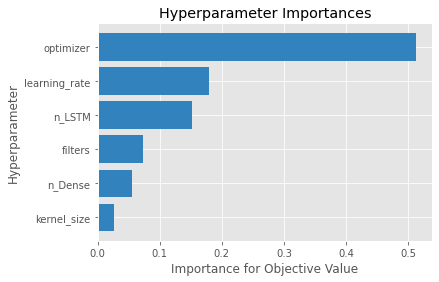

In [113]:
import matplotlib.pyplot as plt

optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

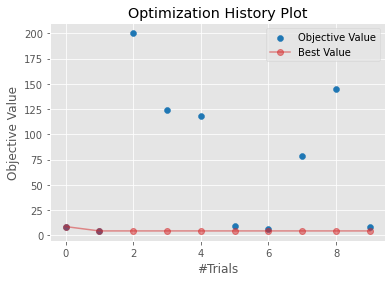

In [114]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

In [115]:
print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  10
Best trial:
  Value:  4.355998895214274
  Params: 
    filters: 8
    kernel_size: 10
    n_LSTM: 64
    n_Dense: 16
    optimizer: Adam
    learning_rate: 0.001093044004764918


In [142]:
model = Sequential([
            Conv1D(filters=study.best_params['filters'], 
                   kernel_size=study.best_params['kernel_size'],
                   padding = 'causal',
                   activation = 'relu',
                   input_shape = [WINDOW_SIZE, 3] 
                  ),
            LSTM(study.best_params['n_LSTM'], activation='tanh'),
            Dense(study.best_params['n_Dense'], activation = 'relu'),
            Dense(1)
        ])

if study.best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate = study.best_params['learning_rate'])
elif study.best_params['optimizer'] == 'SGD':
    optimizer = SGD(learning_rate = study.best_params['learning_rate'], momentum = study.best_params['momentum'] )
    
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# earlystopping = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'btt_with_volume_checkpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

train_data, test_data = get_tensor_data()

history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=50,
                    callbacks=[checkpoint, ])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

 sMAPE : 5.337433426964483


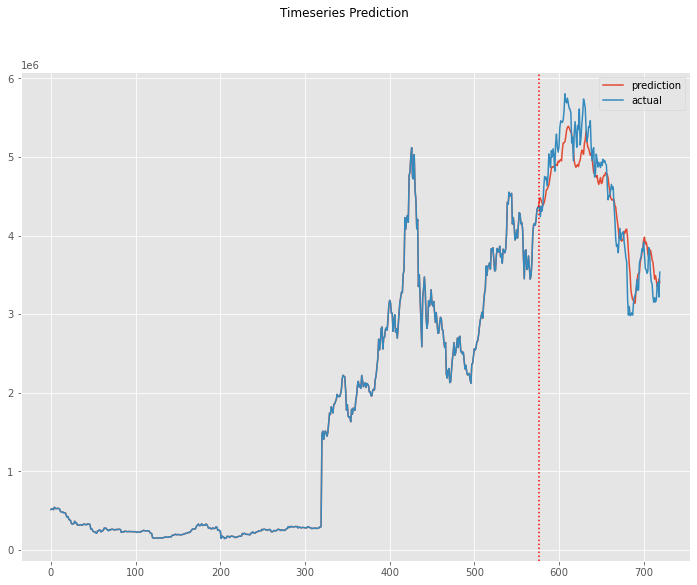

In [144]:
model.load_weights(filename)
pred = model.predict(test_data)

pred_plot = np.concatenate((test[WINDOW_SIZE:,0:2], pred), axis=1)
pred_plot = np.concatenate((train, pred_plot), axis=0)
pred_plot = scaler.inverse_transform(pred_plot)[:,2]

actual_plot = scaler.inverse_transform(scaled)[:,2]

print(f' sMAPE : {smape(actual_plot[train.shape[0]:], pred_plot[train.shape[0]:])}')

plt.figure(figsize=(12,9))
plt.plot(pred_plot, label='prediction')
plt.plot(actual_plot, label='actual')
plt.axvline(x=train.shape[0], c='r', linestyle=':')
plt.suptitle('Timeseries Prediction')
plt.legend()
plt.show();

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
sMAPE = 3.7954828112090526


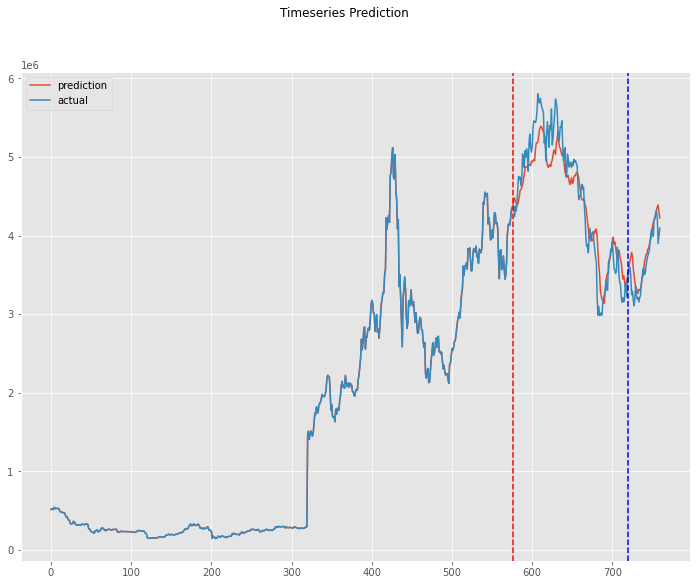

In [145]:
with open('../data/crypto_currency_oot.pickle','rb') as f:
    oot_data = pickle.load(f)
    
oot_btt = oot_data['KRW-ETH']
oot_scaled = scaler.transform(oot_btt[scale_cols])
oot_scaled = np.concatenate((test[-WINDOW_SIZE:,:], oot_scaled), axis=0)
oot_test_data = window_dataset(oot_scaled, WINDOW_SIZE, BATCH_SIZE, False)

oot_pred = model.predict(oot_test_data)


oot_pred_plot = np.concatenate((oot_scaled[WINDOW_SIZE:,0:2], oot_pred), axis = 1)
pred_plot = np.concatenate((test[WINDOW_SIZE:,0:2], pred), axis = 1)
oot_pred_plot = scaler.inverse_transform(np.concatenate((train, pred_plot, oot_pred_plot)))[:, 2]
oot_actual_plot = scaler.inverse_transform(np.concatenate((train, test[WINDOW_SIZE:, :], oot_scaled[WINDOW_SIZE:, :])))[:, 2]

print(f'sMAPE = {smape(oot_actual_plot[scaled.shape[0]:], oot_pred_plot[scaled.shape[0]:])}')

plt.figure(figsize=(12, 9))
plt.plot(oot_pred_plot, label='prediction')
plt.plot(oot_actual_plot, label='actual')
plt.axvline(x = train.shape[0], c = 'r', linestyle = '--')
plt.axvline(x = scaled.shape[0], c = 'b', linestyle = '--')
plt.suptitle('Timeseries Prediction')
plt.legend()
plt.show()